In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils import errors
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.utils import visualizations as vis
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN
import yaml
from pathlib import Path


In [25]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/lorenz63/run_20231229_144327') 
config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 3
  input_only_mode: false
  input_vars:
  - x
  - y
  - z
  input_weights_mode: sparse_grouped
  network_dt: 0.01
  param_vars:
  - beta
  - rho
  - sigma
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  washout_time: 4
random_seed: 41
simulation:
  beta_list:
  - 1.3333333333333333
  - 1.6666666666666667
  - 2.0
  - 2.3333333333333335
  - 2.6666666666666665
  noise_level: 0
  rho_list:
  - 30
  - 35
  - 40
  - 45
  - 50
  sigma_list:
  - 10
  - 11
  - 12
  - 13
  - 14
  sim_dt: 0.001
  sim_time: 300
  transient_time: 20
train:
  regime_selection: 40
  tikhonov: 0.001
  time: 10
val:
  error_measure: rel_L2
  fold_time: 2
  hyperparameters:
    input_scaling:
      max: 1.0
      min: 0.0001
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.01
      scale: log10
    parameter_normalization_mean:
      beta:
        max: 2.0
        min: -2.0
        scale: uniform
      rho:
        max: 40.0
        min: -40.0
     

## Generate data

In [26]:
try:
    integrator = config.simulation.integrator
except:
    integrator = 'odeint'

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]

train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# length of training time series
train_time = config.train.time

loop_names=['train']
loop_times = [train_time]

eParam = Lorenz63.get_eParamVar()
DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    regime_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.


### Plot data

In [ ]:
len_p_list=len(train_param_list)
plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2],]
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=f"rho = {train_param_list[p_idx]}",
                   xlabel='t')
        plt.xlim([washout_time,20+washout_time])

    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx_pairs):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_phase_space(DATA["train"]["u"][p_idx],
                            idx_pair=k,
                            title=f"rho = {train_param_list[p_idx]}")

## Train 

In [27]:
res_idx = 0
ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
        "dimension": dim,
    }
print('System dimension: ', dim)

hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][res_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][res_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)

ESN_dict['input_seeds'] = [5,6,7]
ESN_dict['reservoir_seeds'] = [8,9]

my_ESN = ESN(**ESN_dict)
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

System dimension:  3
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Reservoir weights are rescaled with the new spectral radius.
Input weights are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.


c:\Users\egeoz\Imperial\Adjoint-ESN\env\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.61203e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Predict and visualize

Running solver.


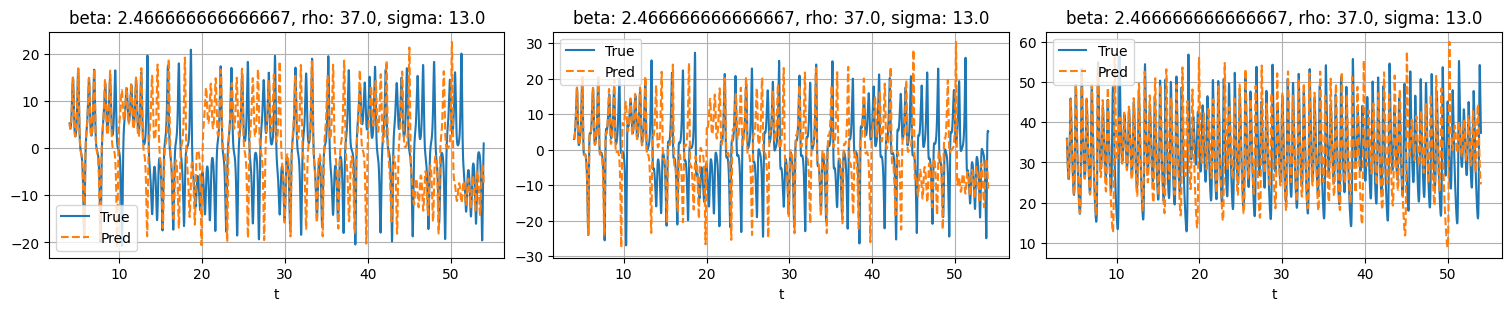

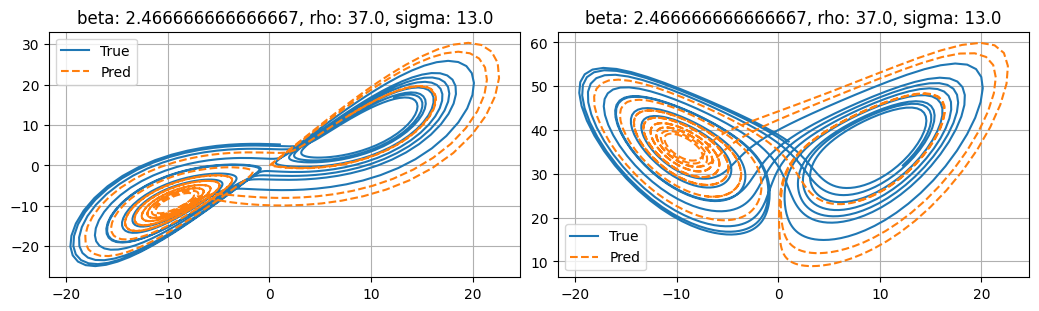

In [28]:
sim_time = 74
loop_times = [50]
param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = [7.4/3]
param_mesh_input[eParam.rho] = [37]
param_mesh_input[eParam.sigma] = [13]
p_list = pp.make_param_mesh(param_mesh_input)

plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2],]
phase_space_steps = pp.get_steps(10,network_dt)

error_measure = errors.rel_L2

for p_idx, p in enumerate(p_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        regime_str = f'beta: {p[eParam.beta]}, rho: {p[eParam.rho]}, sigma: {p[eParam.sigma]}'
        # plot time series
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        # plot phase space  
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])

        # plot statistics    
        # plt.figure(figsize = (15,3),constrained_layout=True)
        # for j, k in enumerate(plt_idx):
        #     plt.subplot(1,len(plt_idx),j+1)
        #     vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
        #                         title=regime_str,
        #                         ylabel='PDF',
        #                         linestyle=['-','--'],
        #                         legend=['True','Pred'])
        # plt.figure(figsize = (15,3),constrained_layout=True)

## Statistics

In [6]:
# generate and train ESN realisations
n_ensemble = 1
res_idx = 0
ESN_list = [None] * n_ensemble
for e_idx in range(n_ensemble):
    # fix the seeds
    input_seeds = [5 * e_idx, 5 * e_idx + 1, 5 * e_idx + 2]
    reservoir_seeds = [5 * e_idx + 3, 5 * e_idx + 4]

    # expand the ESN dict with the fixed seeds
    ESN_dict["input_seeds"] = input_seeds
    ESN_dict["reservoir_seeds"] = reservoir_seeds
    ESN_dict["verbose"] = False
    my_ESN = ESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

    my_ESN.train(DATA["train"]["u_washout"], 
                DATA["train"]["u"], 
                DATA["train"]["y"],
                P_washout=DATA["train"]["p_washout"], 
                P_train=DATA["train"]["p"],
                train_idx_list=train_idx_list)
    ESN_list[e_idx] = my_ESN

c:\Users\egeoz\Imperial\Adjoint-ESN\env\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.57318e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Running solver.
Running solver.
Running solver.


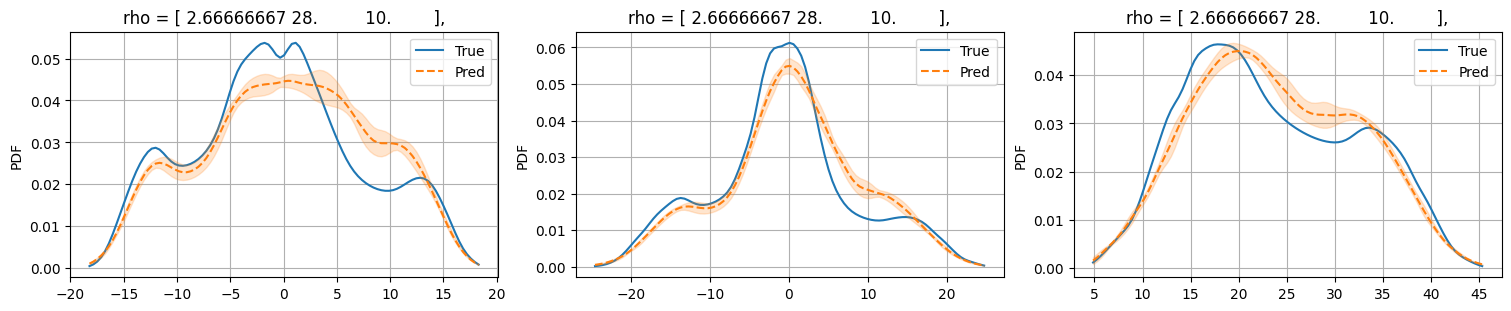

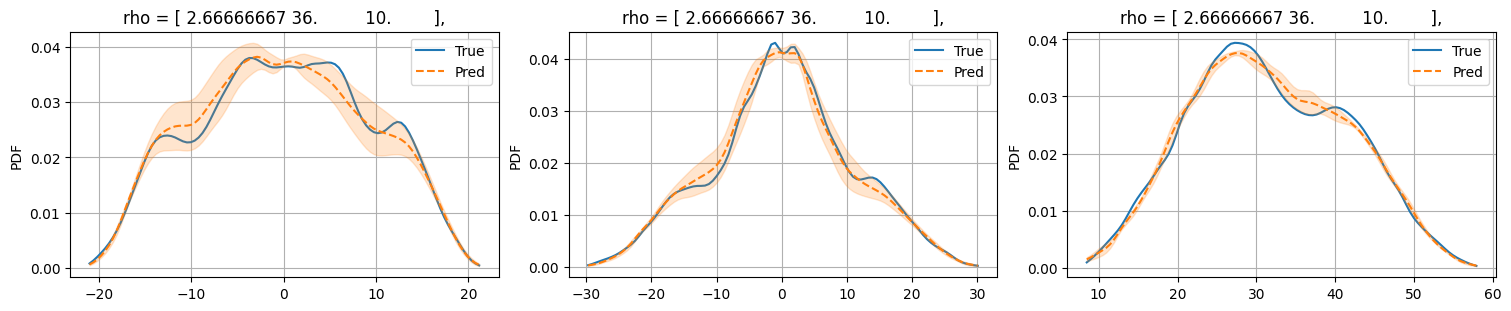

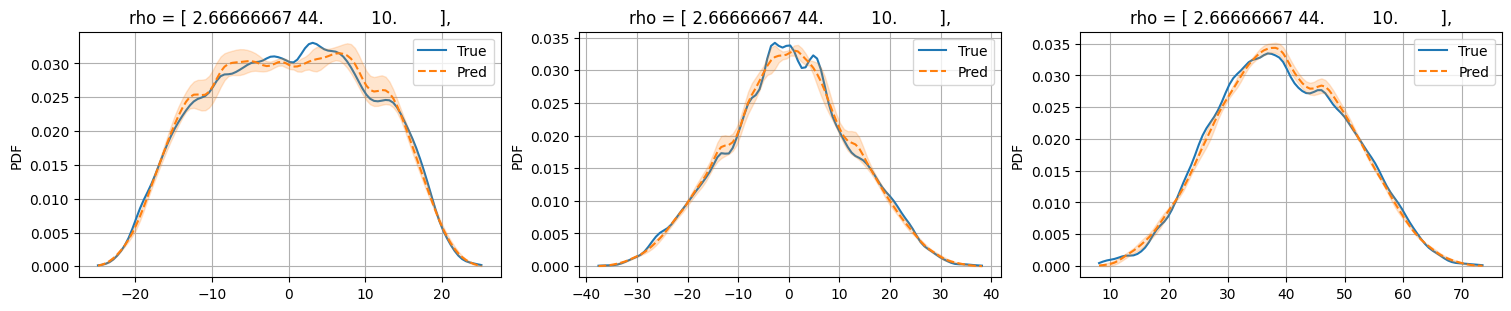

In [41]:
sim_time = 224
loop_times = [200]
param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = config.simulation.beta_list
param_mesh_input[eParam.rho] = [28,36,44]
param_mesh_input[eParam.sigma] = config.simulation.sigma_list
p_list = pp.make_param_mesh(param_mesh_input)

plt_idx = [0,1,2]

for p_idx, p in enumerate(p_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in data.keys():
        Y_PRED = [None] * n_ensemble
        for e_idx, my_ESN in enumerate(ESN_list):
            _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                        N_t=len(data[loop_name]["u"]), 
                                                        P_washout=data[loop_name]["p_washout"],  
                                                        P=data[loop_name]["p"])
            y_pred = y_pred[1:]
            Y_PRED[e_idx] = y_pred
            regime_str = f'rho = {p},'

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics_ensemble(*[Y_PRED[e][:, k] for e in range(n_ensemble)],
                                y_base=data[loop_name]["y"][:,k],
                                title=regime_str,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'],
                                color=["tab:blue","tab:orange"])

In [37]:
sim_time = 224
loop_times = [200]

param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = [8/3]
param_mesh_input[eParam.rho] = np.arange(30,40,0.5)
param_mesh_input[eParam.sigma] = [12]
p_list = pp.make_param_mesh(param_mesh_input)

plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2],]
phase_space_steps = pp.get_steps(10,network_dt)

error_measure = errors.rel_L2
z_bar = np.zeros(len(p_list))
z_bar_pred_mean = np.zeros(len(p_list))
z_bar_pred_std = np.zeros(len(p_list))

for p_idx, p in enumerate(p_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    z_bar[p_idx] = np.mean(data[loop_name]["y"][:,2])
    z_bar_pred = np.zeros(n_ensemble)
    for e_idx, my_ESN in enumerate(ESN_list):
        for loop_name in data.keys():
            _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                        N_t=len(data[loop_name]["u"]), 
                                                        P_washout=data[loop_name]["p_washout"],  
                                                        P=data[loop_name]["p"])
            y_pred = y_pred[1:]

            z_bar_pred[e_idx] = np.mean(y_pred[:,2])
    z_bar_pred_mean[p_idx] = np.mean(z_bar_pred)
    z_bar_pred_std[p_idx] = np.std(z_bar_pred)

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.


KeyboardInterrupt: 

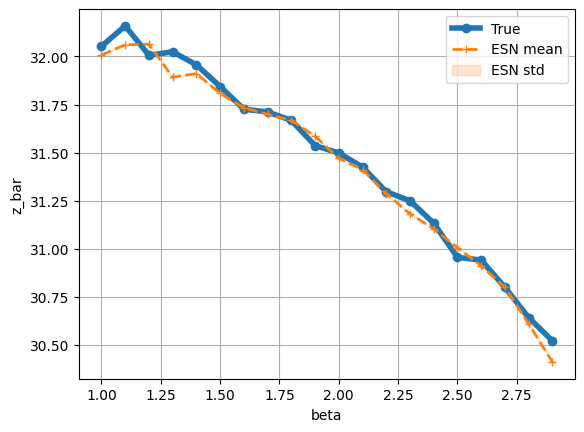

In [109]:
plt.plot(p_list[:,eParam.beta],z_bar,'-o',linewidth=4)
plt.plot(p_list[:,eParam.beta],z_bar_pred_mean, '--+', color="tab:orange",linewidth=2)
plt.fill_between(p_list[:,eParam.beta], z_bar_pred_mean+z_bar_pred_std, z_bar_pred_mean-z_bar_pred_std, color="tab:orange",alpha=0.2)
plt.xlabel("beta")
plt.ylabel("z_bar")
plt.legend(["True","ESN mean","ESN std","Train","Validation"])
plt.grid()

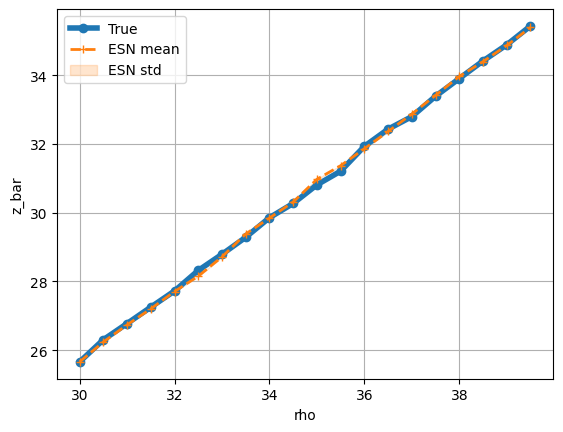

In [119]:
plt.plot(p_list[:,eParam.rho],z_bar,'-o',linewidth=4)
plt.plot(p_list[:,eParam.rho],z_bar_pred_mean, '--+', color="tab:orange",linewidth=2)
plt.fill_between(p_list[:,eParam.rho], z_bar_pred_mean+z_bar_pred_std, z_bar_pred_mean-z_bar_pred_std, color="tab:orange",alpha=0.2)
plt.xlabel("rho")
plt.ylabel("z_bar")
plt.legend(["True","ESN mean","ESN std","Train","Validation"])
plt.grid()

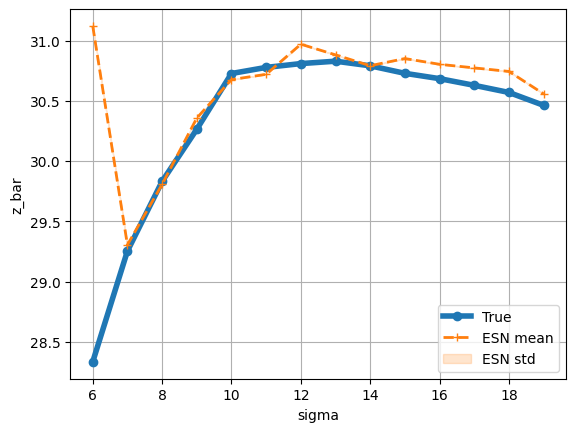

In [115]:
plt.plot(p_list[:,eParam.sigma],z_bar,'-o',linewidth=4)
plt.plot(p_list[:,eParam.sigma],z_bar_pred_mean, '--+', color="tab:orange",linewidth=2)
plt.fill_between(p_list[:,eParam.sigma], z_bar_pred_mean+z_bar_pred_std, z_bar_pred_mean-z_bar_pred_std, color="tab:orange",alpha=0.2)
plt.xlabel("sigma")
plt.ylabel("z_bar")
plt.legend(["True","ESN mean","ESN std","Train","Validation"])
plt.grid()

## Lyapunov stability analysis

In [47]:
params = {"beta": 8/3,
          "rho": 30,
          "sigma": 10}

sim_time = 124
loop_times = [100]
loop_names = ["test"]
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=["x","y","z"],
                    param_vars=["rho"],
                    loop_times=loop_times,
                    loop_names=loop_names)

LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_sys,
                                 sys_type='continuous',
                                 X=data["test"]["u"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=network_dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,network_dt)

Running solver.
[ 9.81947652e-01 -1.17788826e-02 -1.46367305e+01]


In [48]:
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["test"]["u_washout"], 
                                                        N_t=len(data["test"]["u"]), 
                                                        P_washout=data["test"]["p_washout"],  
                                                        P=data["test"]["p"])
y_pred = y_pred[1:]
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='ESN',
                                 X=x_pred,
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=network_dt,
                                 target_dim=my_sys.N_dim,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,network_dt)

[ 9.61417829e-01 -3.25558194e-03 -1.46409677e+01]


## Sensitivity

In [29]:
from adjoint_esn.utils import dynamical_systems_sensitivity as sens

def objective_fun(u):
    return np.mean(u[:,2])

def dobjective_fun(u):
    return np.array([0,0,1])

# def objective_fun(u):
#     return np.mean(np.sum(u, axis=1))

# def dobjective_fun(u):
#     return np.array([1,1,1])

# def objective_fun(u):
#     return np.mean(np.sum(u**2, axis=1))

# def dobjective_fun(u):
#     return 2*u

params = {"beta": 8/3,
            "rho": 35.0,
            "sigma": 12.0}

sim_time = 1.0
sim_dt = 1e-3
for random_seed in range(1):
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=random_seed)

    dJdp_direct = sens.true_direct_sensitivity(my_sys, t_sim, y_sim, dobjective_fun)
    dJdp_adj = sens.true_adjoint_sensitivity(my_sys, t_sim, y_sim, dobjective_fun)
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_sys, t_sim, y_sim, h=1e-8, objective_fun=objective_fun, method="central")
    print('Direct', dJdp_direct)
    print('Adjoint', dJdp_adj)
    print('Finite', dJdp_finite)

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Direct [0.26815013 0.94352998 0.10596712]
Adjoint [0.26814649 0.94352887 0.10596897]
Finite [0.26701574 0.9442644  0.10687682]


In [36]:
sim_time = 30
loop_times = [1.0]
transient_time = 20.0
washout_time = 4.0

param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = [8/3]
param_mesh_input[eParam.rho] = [32]
param_mesh_input[eParam.sigma] = [14.0]
p_list = pp.make_param_mesh(param_mesh_input)

methods = ['direct','adjoint','finite']
dJdp = {'true':{},'esn':{}}
for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),my_sys.N_param))
    dJdp['esn'][method_name] = np.zeros((len(p_list),len(param_vars)))

for p_idx, p in enumerate(p_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)
    N_transient = pp.get_steps(transient_time,sim_dt)
    y_bar = y_sim[N_transient:,:]
    t_bar = t_sim[N_transient:]

    N_washout = pp.get_steps(washout_time,sim_dt)
    N_loop = pp.get_steps(loop_times[0],sim_dt)+1
    y_bar = y_bar[N_washout:N_washout + N_loop,:]
    t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]

    dJdp["true"]["direct"][p_idx] = sens.true_direct_sensitivity(my_sys, t_bar, y_bar, dobjective_fun)
    dJdp["true"]["adjoint"][p_idx] = sens.true_adjoint_sensitivity(my_sys, t_bar, y_bar, dobjective_fun)
    dJdp["true"]["finite"][p_idx] = sens.true_finite_difference_sensitivity(
        my_sys, t_bar, y_bar, h=1e-5, objective_fun=objective_fun, method="central")

    print('J: ', objective_fun(data[loop_name]["y"]))
    print('Direct:', dJdp["true"]["direct"][p_idx])
    print('Adjoint:', dJdp["true"]["adjoint"][p_idx])
    print('Finite:', dJdp["true"]["finite"][p_idx])
      
    for loop_name in data.keys():   
        N = len(data[loop_name]["u"])
        x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=N, 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])

        dJdp["esn"]["direct"][p_idx] = my_ESN.direct_sensitivity(x_pred, y_pred, N, dJdy_fun=dobjective_fun)
        dJdp["esn"]["adjoint"][p_idx] = my_ESN.adjoint_sensitivity(x_pred, y_pred, N, dJdy_fun=dobjective_fun)                    
        dJdp["esn"]["finite"][p_idx] = my_ESN.finite_difference_sensitivity(X=x_pred, 
                                                            Y=y_pred,  
                                                            P=data[loop_name]["p"], 
                                                            N=N, 
                                                            h=1e-5,
                                                            method="central",
                                                            J_fun=objective_fun)
        print('J esn: ', objective_fun(y_pred[1:]))
        print('Direct esn:', dJdp["esn"]["direct"][p_idx])
        print('Adjoint esn:', dJdp["esn"]["adjoint"][p_idx])
        print('Finite esn:', dJdp["esn"]["finite"][p_idx])

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
J:  30.255811468946046
Direct: [-2.21322358  0.4558923  -0.02260043]
Adjoint: [-2.21322192  0.45589285 -0.02260018]
Finite: [-2.20856177  0.45650054 -0.02269356]
J esn:  30.24471835940673
Direct esn: [-6.1586567  -0.29352812 -0.03706167]
Adjoint esn: [-6.1586567  -0.29352812 -0.03706167]
Finite esn: [-6.15865673 -0.29352814 -0.03706168]


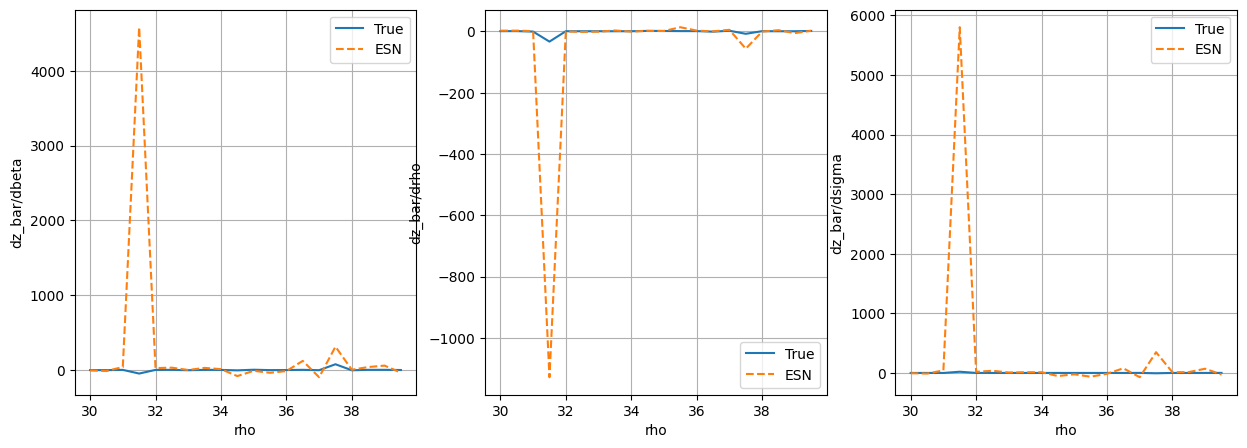

In [122]:
plt.figure(figsize=(15,5))
for i, param in enumerate(param_vars):
    plt.subplot(1,len(param_vars),i+1)
    vis.plot_lines(p_list[:,eParam.rho],
                dJdp["true"]["adjoint"][:,eParam[param]],
                dJdp["esn"]["adjoint"][:,eParam[param]],
                linestyle=["-","--"],
                xlabel="rho",
                ylabel=f"dz_bar/d{param}",
                )

    plt.legend(["True","ESN"])